In [1]:
from numpy.random import seed
seed(8)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection 
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras import regularizers

In [2]:
def read_in_and_split_data(iris_data):

    # Load the diabetes dataset
    dataset = iris_data
    
    data = dataset["data"]
    targets = dataset['target']
    
    # targets = (targets - targets.mean(axis=0)) / targets.std()

    # Split the data into train and test sets

    from sklearn.model_selection import train_test_split

    train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)
    return train_data, test_data, train_targets, test_targets

In [3]:
iris_data = datasets.load_iris()
train_data, test_data, train_targets, test_targets = read_in_and_split_data(iris_data)

In [4]:
train_targets.max(), train_targets.min(), test_targets.max(), test_targets.min()

(2, 0, 2, 0)

In [5]:
train_targets = tf.keras.utils.to_categorical(np.array(train_targets))
test_targets = tf.keras.utils.to_categorical(np.array(test_targets))

In [6]:
# tf.keras.initializers.he_uniform()
# tf.keras.initializers.HeNormal()

def get_model(input_shape):

    model = Sequential([      
            Dense(64, kernel_initializer=tf.keras.initializers.HeNormal(), 
                  bias_initializer=tf.keras.initializers.Constant(value=1), input_shape=input_shape, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            Dense(3, activation="softmax")
    ])
    
    return model   

In [7]:
model = get_model(train_data[0].shape)

In [8]:
# 'categorical_crossentropy'은 y[0]=[0, 0, 0, 0, 0, 0, 0, 0, 1], y[1, 0, 0, 0, 0, 0, 0, 0, 0]과 같이 one-hot-encoding label일 경우에 사용
def compile_model(model):

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(optimizer = opt, 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
        

In [9]:
compile_model(model)

In [10]:
def train_model(model, train_data, train_targets, epochs):
    
    history = model.fit(train_data, train_targets, epochs=epochs, validation_split=0.15, batch_size=40, verbose=False)
    return history

In [11]:
history = train_model(model, train_data, train_targets, epochs=800)

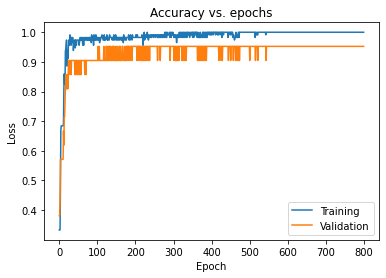

In [12]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

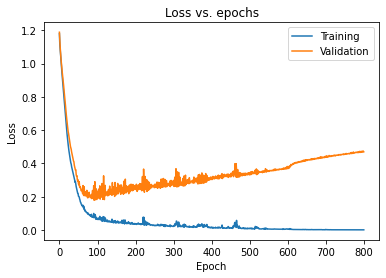

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [14]:
def get_regularised_model(input_shape, dropout_rate, weight_decay):

    model = Sequential([
            Dense(64, kernel_initializer=tf.keras.initializers.HeNormal(), 
                  bias_initializer=tf.keras.initializers.Constant(value=1),
                  kernel_regularizer=regularizers.l2(weight_decay),
                  activation="relu", input_shape=input_shape),
            Dense(128, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dense(128, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dropout(dropout_rate),
            Dense(128, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dense(128, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            BatchNormalization(),
            Dense(64, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dense(64, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dropout(dropout_rate),
            Dense(64, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dense(64, kernel_regularizer=regularizers.l2(weight_decay), activation="relu"),
            Dense(3, activation="softmax")
    ])
    
    return model

In [15]:
reg_model = get_regularised_model(train_data[0].shape, 0.3, 0.001)

In [16]:
compile_model(reg_model)

In [17]:
reg_history = train_model(reg_model, train_data, train_targets, epochs=800)

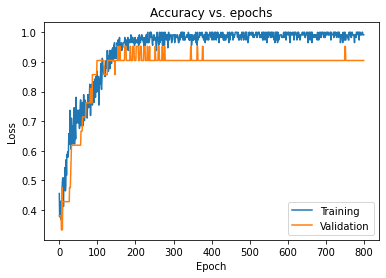

In [18]:
try:
    plt.plot(reg_history.history['accuracy'])
    plt.plot(reg_history.history['val_accuracy'])
except KeyError:
    plt.plot(reg_history.history['acc'])
    plt.plot(reg_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

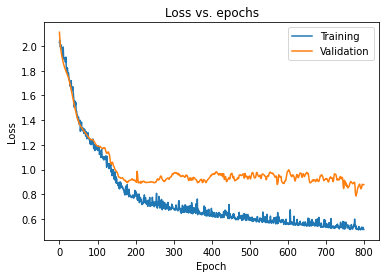

In [19]:
plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [20]:
def get_callbacks():

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=30, mode="min")
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=20, verbose=1)
    
    return early_stopping, learning_rate_reduction

In [21]:
call_model = get_regularised_model(train_data[0].shape, 0.3, 0.0001)
compile_model(call_model)
early_stopping, learning_rate_reduction = get_callbacks()
call_history = call_model.fit(train_data, train_targets, epochs=800, validation_split=0.15,
                         callbacks=[early_stopping, learning_rate_reduction], verbose=0)


Epoch 177: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.


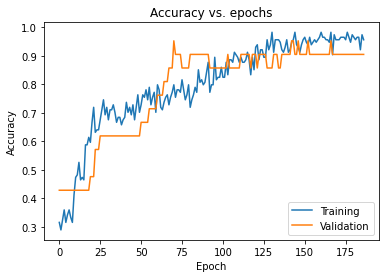

In [22]:
try:
    plt.plot(call_history.history['accuracy'])
    plt.plot(call_history.history['val_accuracy'])
except KeyError:
    plt.plot(call_history.history['acc'])
    plt.plot(call_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

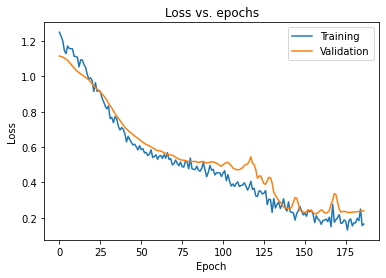

In [23]:
plt.plot(call_history.history['loss'])
plt.plot(call_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [24]:
test_loss, test_acc = call_model.evaluate(test_data, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.113
Test accuracy: 100.00%
